# MNIST GAN


## Resources
* [NIPS 2016 Tutorial:
Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf)

## Requirements
* TensorFlow 1.15
* Numpy
* Matplotlib

## MNIST Dataset

Load MNIST, normalize images and display examples

In [4]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.datasets.mnist import load_data
(train_X, train_y), (test_X, test_y) = load_data()

print("Shape of dataset:")
train_X.shape, train_y.shape, test_X.shape, test_y.shape

1.15.2
Shape of dataset:


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
train_X_normalized = train_X / 255.
test_X_normalized = test_X / 255.
train_X_normalized_reshaped = train_X_normalized.reshape(-1, 28, 28, 1)
test_X_normalized_reshaped = test_X_normalized.reshape(-1, 28, 28, 1)

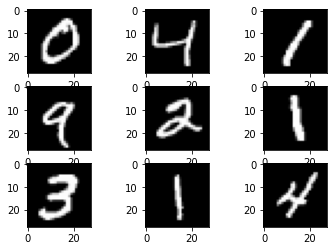

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_X_normalized_reshaped[i+1,:,:,0], cmap='gray')

## Discriminator

The aim of the discriminator is to classify images as "fake" or "real".
For this exercise a simply CNN is implemented which accepts images in the shape of the MNIST dataset:

1. **```Input```**: Accepts 28px x 28px monochromatic images
2. **```Conv2D```**: Filter size 5x5, 32 feature maps, ```SAME``` padding, ReLU Activation 
3. **```Average Pooling```**: 2x2 kernel, 2x2 stride
4. **```Conv2D```**: Filter size 5x5, 64 feature maps, ```SAME``` padding, ReLU Activation
5. **```Average Pooling```**: 2x2 kernel, 2x2 stride
6. **```Dense```**: 1024 neurons, ReLU activation
7. **```Dense```**: 1 neuron, linear activation

We'll later minimize the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) during training. Instead of outputting a probability distribution at the output layer of the discriminator, we'll instead use the logits, since TensorFlow provides a [```sigmoid_cross_entropy_with_logits```](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) function which is supposed to be [better suited for training](https://github.com/tensorflow/tensorflow/issues/2462).


In [7]:
def build_discriminator(images, reuse):
    with tf.variable_scope('discriminator') as var_scope:
        if reuse:
            var_scope.reuse_variables()
        
        conv1_tf = tf.layers.Conv2D(filters=32, kernel_size=[5,5], padding='same',
                                    activation=tf.nn.relu, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))(images)
        avg_pool1_tf = tf.layers.AveragePooling2D(pool_size=[2,2], strides=2)(conv1_tf)

        conv2_tf = tf.layers.Conv2D(filters=64, kernel_size=[5,5], padding='same',
                                    activation=tf.nn.relu, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))(avg_pool1_tf)
        avg_pool2_tf = tf.layers.AveragePooling2D(pool_size=[2,2], strides=2)(conv2_tf)
        
        flatten1_tf = tf.layers.Flatten()(avg_pool2_tf)
        dense1_tf = tf.layers.Dense(units=1024, activation=tf.nn.relu, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))(flatten1_tf)
        dense2_tf = tf.layers.Dense(units=1, activation='linear', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))(dense1_tf)
    
        return dense2_tf

## Generator
The generator is trained to produce images which deceive the discriminator. Ideally, this results in images which look like they originate from the dataset distribution, since the discriminator is trained to distinguish data which lies in or outside the distribution.
For this purpose, the generator takes a noise vector as input which is then upsampled and modified through multiple layers of convolutions:

1. **```Input```**: Accepts a noise vector of length $N=100$
2. **```Dense```**: upsamples the input vector to length $3136 (56*56)$, applies ReLU activation function
3. **```Conv2D```**: Filter size 3x3, 2x2 strides, $N/2$ feature maps, ```SAME``` padding, ReLU activation
4. **```BatchNormalization```**: Default parameters
5. **```Upsample2D```**: factor 2x2, bilinear
5. **```Conv2D```**: Filter size 3x3, 2x2 strides, $N/4$ feature maps, ```SAME``` padding, ReLU activation
7. **```BatchNormalization```**: Default parameters
8. **```Upsample2D```**: factor 2x2, bilinear
9. **```Conv2D```**: Filter size 3x3, 2x2 strides, 1 feature map, sigmoid activation

In [8]:
def build_generator(input_tf):
    with tf.variable_scope('generator') as var_scope:
        
        L_sqrt = 56
        L = L_sqrt*L_sqrt
        N = input_tf.shape[1]
        
        dense1_tf = tf.layers.Dense(units=L, activation=tf.nn.relu, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))(input_tf)

        dense1_reshaped_tf = tf.reshape(dense1_tf, [-1, L_sqrt, L_sqrt, 1])

        conv1_tf = tf.layers.Conv2D(filters=N//2, kernel_size=[3,3],
                                   padding='same', strides=2, activation='linear', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))(dense1_reshaped_tf)

        batchnorm1_tf = tf.layers.BatchNormalization()(conv1_tf)

        activation1_tf = tf.keras.layers.Activation(tf.nn.relu)(batchnorm1_tf)

        upsample1_tf = tf.image.resize_images(activation1_tf, (L_sqrt, L_sqrt))

        conv2_tf = tf.layers.Conv2D(filters=N//4, kernel_size=[3,3],
                                   padding='same', strides=2, activation='linear', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))(upsample1_tf)
        
        batchnorm2_tf = tf.layers.BatchNormalization()(conv2_tf) 
        
        activation2_tf = tf.keras.layers.Activation(tf.nn.relu)(batchnorm2_tf)

        upsample2_tf = tf.image.resize_images(activation2_tf, (L_sqrt, L_sqrt))
        
        conv3_tf = tf.layers.Conv2D(filters=1, kernel_size=[3,3],
                                    strides=2, activation=tf.nn.sigmoid,  padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))(upsample2_tf)
        return conv3_tf

### Test the generator

(1, 28, 28, 1)


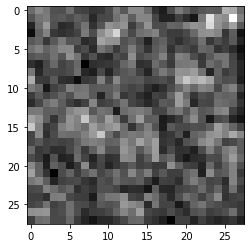

In [ ]:
import numpy as np

tf.reset_default_graph()

session = tf.Session()
noise_vec = np.random.rand(1,100)
input_tf = tf.placeholder(shape=(None, noise_vec.shape[1]), dtype=tf.float32, name='input')

generator_op = build_generator(input_tf)

session.run(tf.global_variables_initializer())

params = {input_tf: noise_vec}
generated_image = session.run(generator_op, feed_dict=params)

session.close()

print(generated_image.shape)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

tf.reset_default_graph()

## Assemble the GAN

Time to put the pieces together!

* We'll create the ```tf.placeholders``` to feed images ```x``` and the noise vector ```z```
* We instantiate the generator ```Gz```
* We instantiate the discriminator ```Dx``` for the real data and ```Dg``` for the generated data. By setting ```reuse=True``` we'll make sure that we share the underlying variables.

In [9]:
tf.reset_default_graph()

# real images
x = tf.placeholder(shape=(None, 28, 28), dtype=tf.float32, name='input_x') 
x_reshaped = tf.reshape(x, [-1, 28, 28, 1])

# noise vector
z = tf.placeholder(shape=(None, 100), dtype=tf.float32, name='input_z')

Gz = build_generator(z)
Dx = build_discriminator(x_reshaped, reuse=False)
Dg = build_discriminator(Gz, reuse=True)

## Training the GAN
In a GAN, the discriminator tries to minimize its loss, meaning it is trained to be good at discriminating real from fake data. However, the generator tries to maximize the loss of the discriminator, meaning it is able to generate data that is classified as "real" to the discriminator. Therefore, the generator's loss is minimal if the discriminator outputs the wrong label for data produced by the generator.

In [10]:
# Discriminator for real images -> We use ones ("real") as class labels
dx_loss_tf = tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx))
dx_loss_avg_tf = tf.reduce_mean(dx_loss_tf)

# Discriminator for fake images -> We use zeros ("fake") as class labels 
dg_loss_tf = tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg))
dg_loss_avg_tf = tf.reduce_mean(dg_loss_tf)

# The generator procudes fake images labeled as real images.
# -> It tries to maximize the loss of the discriminator.
gz_loss_tf = tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg))
gz_loss_avg_tf = tf.reduce_mean(gz_loss_tf)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Since we want to train generator and discriminator in isolation, we have to provide a list of variables to the optimizer.
If we would optimize the whole graph, training of the generator would update the weights of the discriminator and vice versa, which would prevent them from achieving their goals.

In [ ]:
# Example of generator's variables
tf.trainable_variables(scope='generator')

[<tf.Variable 'generator/dense/kernel:0' shape=(100, 3136) dtype=float32_ref>,
 <tf.Variable 'generator/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d/kernel:0' shape=(3, 3, 1, 50) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d/bias:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'generator/batch_normalization/gamma:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'generator/batch_normalization/beta:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_1/kernel:0' shape=(3, 3, 50, 25) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_1/bias:0' shape=(25,) dtype=float32_ref>,
 <tf.Variable 'generator/batch_normalization_1/gamma:0' shape=(25,) dtype=float32_ref>,
 <tf.Variable 'generator/batch_normalization_1/beta:0' shape=(25,) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_2/kernel:0' shape=(3, 3, 25, 1) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_2/bias:0' shape=(1,) dtype=float32_ref>]

In [ ]:
# During discriminator training we only want to adjust the discriminator weights
dx_optimizer_tf = tf.train.AdamOptimizer(learning_rate=0.0003).minimize(dx_loss_avg_tf,
                                                                       var_list=tf.trainable_variables(scope='discriminator'))
dg_optimizer_tf = tf.train.AdamOptimizer(learning_rate=0.0003).minimize(dg_loss_avg_tf,
                                                                       var_list=tf.trainable_variables(scope='discriminator'))
# During generator training we only want to adjust the generator weights
gz_optimizer_tf = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(gz_loss_avg_tf,
                                                                       var_list=tf.trainable_variables(scope='generator'))  

In [ ]:
# Summaries for Tensorboard
from time import localtime, strftime

tf.summary.scalar('dx_loss_avg_tf',dx_loss_avg_tf)
tf.summary.scalar('dg_loss_avg_tf',dg_loss_avg_tf)
tf.summary.scalar('gz_loss_avg_tf',gz_loss_avg_tf)

tf.summary.image('generated_images', Gz, max_outputs=5)
        
merged = tf.summary.merge_all()

### Initial training run

We have to pre-train the discriminator so it already has an idea what "real" data looks like. This way we ensure, that the generator receives proper "feedback" to adjust its weights in order to produce good "fake" data.

In [ ]:
def gen_random_vec(batch_size):
    return np.random.normal(loc=0.0,scale=1,size=(batch_size, 100))

Pretraining finished.
Iteration  0
Loss dx: 0.64705956
Loss dg: 0.7015815
Loss gz: 0.68459487


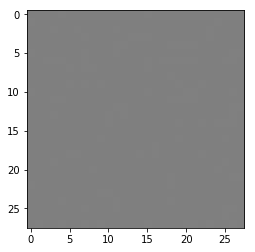

Iteration  100
Loss dx: 0.012450755
Loss dg: 0.0383915
Loss gz: 3.3342228


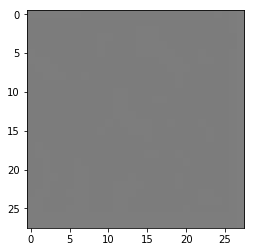

Iteration  200
Loss dx: 0.0013089876
Loss dg: 0.04642135
Loss gz: 3.209965


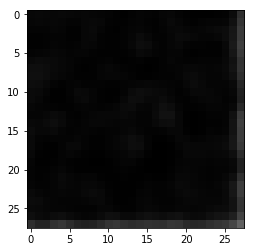

Iteration  300
Loss dx: 0.00054940354
Loss dg: 0.0065494836
Loss gz: 5.023596


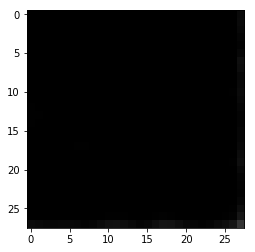

Iteration  400
Loss dx: 6.623022e-05
Loss dg: 0.0032274155
Loss gz: 5.737178


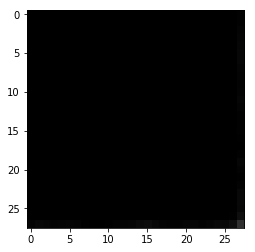

Iteration  500
Loss dx: 0.00018570416
Loss dg: 0.0014401191
Loss gz: 6.528325


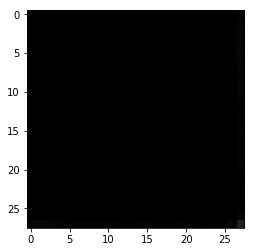

Iteration  600
Loss dx: 3.359334e-05
Loss dg: 0.00090070773
Loss gz: 6.965787


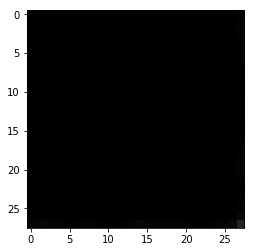

Iteration  700
Loss dx: 0.0001250552
Loss dg: 0.00040739853
Loss gz: 7.750101


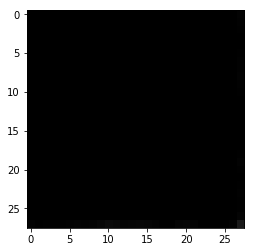

Iteration  800
Loss dx: 6.96635e-05
Loss dg: 0.00031265608
Loss gz: 8.055105


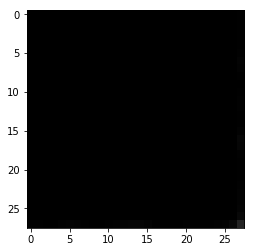

Iteration  900
Loss dx: 8.074925e-06
Loss dg: 0.00021021623
Loss gz: 8.510803


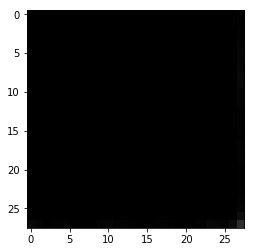

Iteration  1000
Loss dx: 4.073121e-06
Loss dg: 0.0001626417
Loss gz: 8.704889


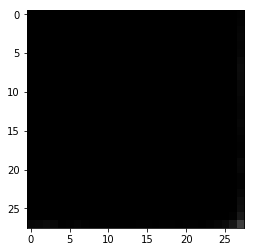

Iteration  1100
Loss dx: 3.2397547e-05
Loss dg: 0.001307676
Loss gz: 6.903644


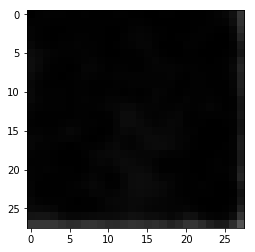

Iteration  1200
Loss dx: 0.02659855
Loss dg: 0.035150263
Loss gz: 4.022063


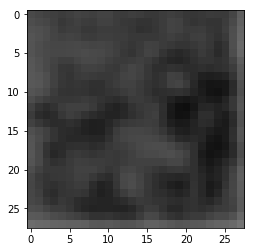

Iteration  1300
Loss dx: 0.052051924
Loss dg: 0.11058457
Loss gz: 2.7224996


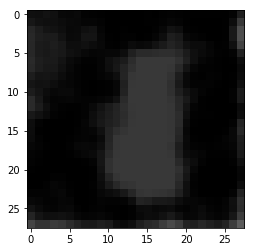

Iteration  1400
Loss dx: 0.010666317
Loss dg: 0.018352475
Loss gz: 7.483535


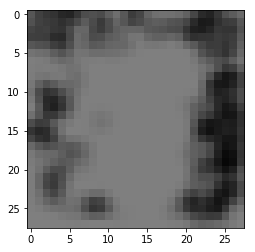

Iteration  1500
Loss dx: 0.06896008
Loss dg: 0.22436655
Loss gz: 1.9056565


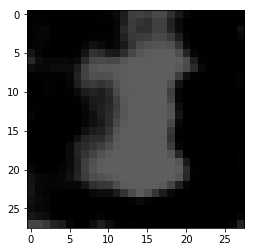

Iteration  1600
Loss dx: 0.64308554
Loss dg: 3.7973168
Loss gz: 1.9888487


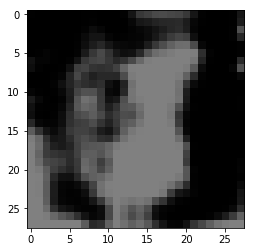

Iteration  1700
Loss dx: 0.12747234
Loss dg: 0.62358063
Loss gz: 10.402098


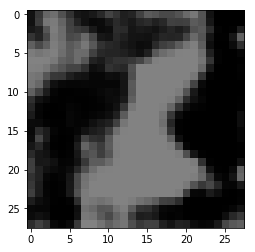

Iteration  1800
Loss dx: 0.05628752
Loss dg: 0.115712695
Loss gz: 12.210721


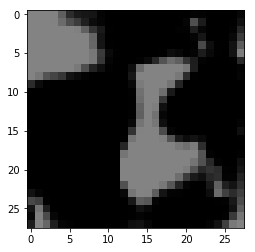

Iteration  1900
Loss dx: 0.048670307
Loss dg: 0.1416452
Loss gz: 7.2534537


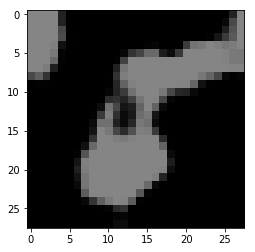

Iteration  2000
Loss dx: 0.06270723
Loss dg: 0.16395894
Loss gz: 5.884583


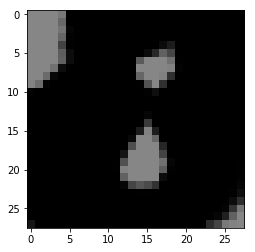

Iteration  2100
Loss dx: 0.03530151
Loss dg: 0.19467281
Loss gz: 5.076603


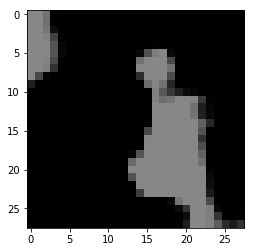

Iteration  2200
Loss dx: 0.038312696
Loss dg: 0.12780224
Loss gz: 6.516943


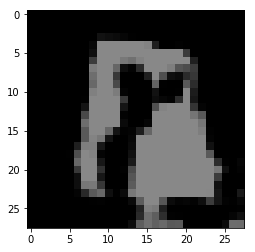

Iteration  2300
Loss dx: 0.029941995
Loss dg: 0.038860187
Loss gz: 6.680717


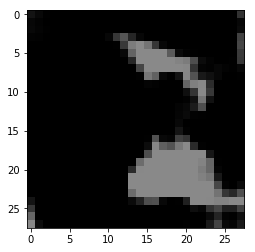

Iteration  2400
Loss dx: 0.026906958
Loss dg: 0.067062974
Loss gz: 6.7471056


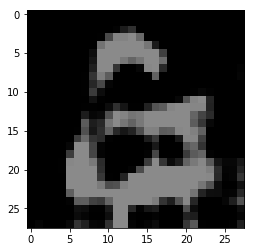

In [ ]:
mini_batch_size = 2048

dataset_training = tf.data.Dataset.from_tensor_slices((train_X_normalized, train_y))
dataset_training = dataset_training.shuffle(buffer_size=train_X_normalized.shape[0]).repeat().batch(mini_batch_size)
it_training = dataset_training.make_one_shot_iterator()
gen_X_values,_ = it_training.get_next()

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    current_time = strftime("%Y_%m_%d__%H_%M", localtime())
    train_writer = tf.summary.FileWriter('./tensorboard/' + current_time,
                                      session.graph)
    
    # Pretraining
    for i in range(20_000//mini_batch_size):
    
        X_batch = session.run(gen_X_values)
    
        # Train the Discriminator
        _,_,loss_dx,loss_dg = session.run([dx_optimizer_tf, dg_optimizer_tf, dx_loss_avg_tf, dg_loss_avg_tf],
                          feed_dict={x:X_batch, z: gen_random_vec(mini_batch_size)})
            
    print('Pretraining finished.')
    
    for j in range(5_000_000//mini_batch_size):
        X_batch = session.run(gen_X_values)
    
        # Train the Discriminator
        _,_,loss_dx,loss_dg = session.run([dx_optimizer_tf, dg_optimizer_tf, dx_loss_avg_tf, dg_loss_avg_tf],
                          feed_dict={x:X_batch, z: gen_random_vec(mini_batch_size)})
        
        # Train Generator
        _,output_gz,loss_gz = session.run([gz_optimizer_tf, Gz, gz_loss_avg_tf],
                                          feed_dict={z: gen_random_vec(mini_batch_size)})
        
        if j%10 == 0:
            summary = session.run(merged,   feed_dict={x:X_batch, z: gen_random_vec(5)})
            train_writer.add_summary(summary, j)
            
        
        if j%100 == 0:
            print('Iteration ',j)
            print('Loss dx:', loss_dx)
            print('Loss dg:', loss_dg)
            print('Loss gz:', loss_gz)
            plt.imshow(output_gz[0,:,:,0], cmap='gray', vmin=0, vmax=1)
            plt.show()

#### Results

Huh, what's that? We expected the generator to produce high quality fake data of the MNIST data distribution but that's actually not the case.
After 2400 mini-batches it seems like the generator learned to produce some kind of shape or structure, but the results do not resemble the MNIST data in any way.
So what exactly is the problem?

By checking the losses we can see that the generator loss keeps increasing, which is not what we expected at all. The training of GANs seems to be highly instable. At first glance it seems to be a good idea to have access to a well trained discriminator, but as it turns out that "as the discriminator gets better, the updates to the generator get consistently worse." ([Arjovsky and Bottou, 2017](https://arxiv.org/pdf/1701.04862.pdf)).
Intuitively, the generator relies on feedback of the discriminator to adjust the weights. If the discriminator is performing too well the error is close to 0 and no feedback can be supplied to the generator.

Let's check our assumption by trying to keep the losses balanced.
For this purpose we'll...
* get rid of the pretraining of the discriminator
* train the generator multiple times per discriminator training iteration

As a result the discriminator should have a harder time to classify images properly, the loss should not converge to 0 and in turn the generator should be able to improve.


## Improvement attempt: Try to keep the losses balanced

Iteration  0
Loss dx: 0.6918227
Loss dg: 0.69567466
Loss gz: 0.6893076


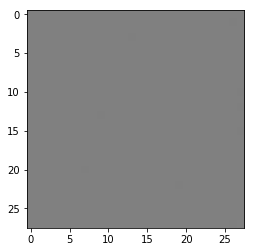

Iteration  1000
Loss dx: 0.24062419
Loss dg: 0.865876
Loss gz: 0.5970303


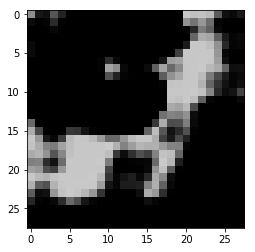

Iteration  2000
Loss dx: 0.36021346
Loss dg: 1.4622552
Loss gz: 0.5615554


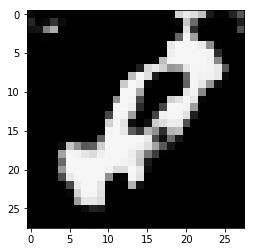

Iteration  3000
Loss dx: 0.3030422
Loss dg: 1.0439732
Loss gz: 0.4454874


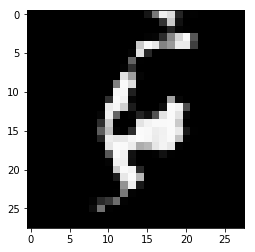

Iteration  4000
Loss dx: 0.31376326
Loss dg: 0.988615
Loss gz: 0.4998519


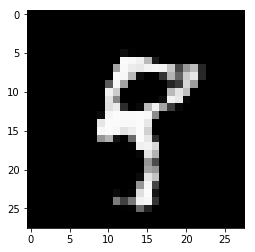

Iteration  5000
Loss dx: 0.2548288
Loss dg: 0.87283224
Loss gz: 0.59180796


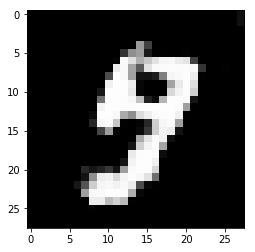

Iteration  6000
Loss dx: 0.28309965
Loss dg: 0.93718815
Loss gz: 0.5301986


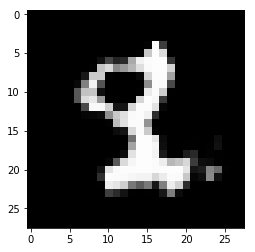

Iteration  7000
Loss dx: 0.23394337
Loss dg: 0.8415618
Loss gz: 0.6605027


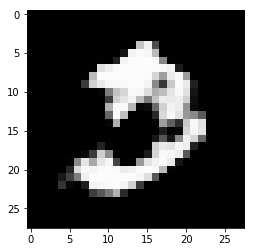

Iteration  8000
Loss dx: 0.3157077
Loss dg: 0.72496486
Loss gz: 0.7840795


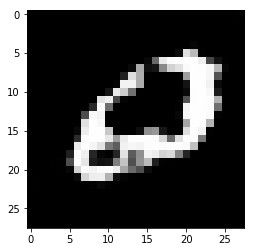

Iteration  9000
Loss dx: 0.25860244
Loss dg: 0.7199276
Loss gz: 0.81095743


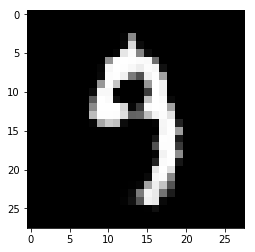

Iteration  10000
Loss dx: 0.30419508
Loss dg: 0.49744695
Loss gz: 0.94998085


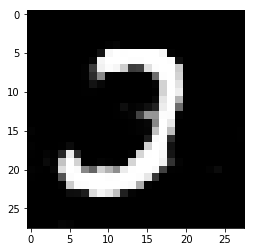

Iteration  11000
Loss dx: 0.34188426
Loss dg: 0.5098658
Loss gz: 0.73895866


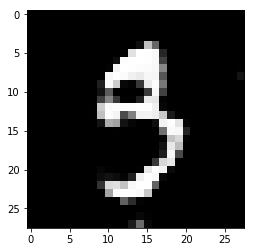

Iteration  12000
Loss dx: 0.2263374
Loss dg: 0.67225426
Loss gz: 0.9775611


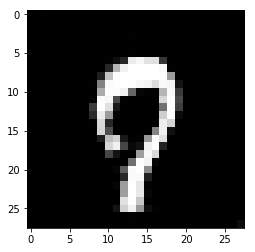

Iteration  13000
Loss dx: 0.2684285
Loss dg: 8.820876
Loss gz: 1.5339787


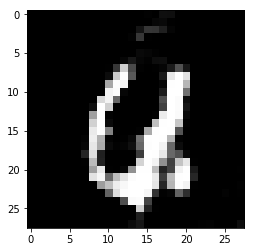

Iteration  14000
Loss dx: 0.33272114
Loss dg: 0.8009153
Loss gz: 0.94443786


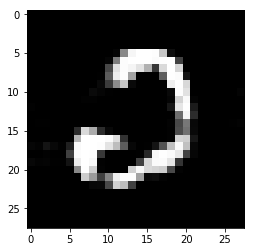

Iteration  15000
Loss dx: 0.8944762
Loss dg: 0.29921642
Loss gz: 0.61704916


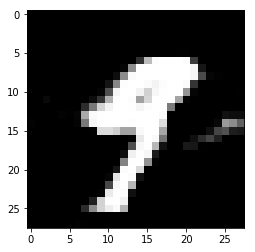

Iteration  16000
Loss dx: 0.33777833
Loss dg: 0.8437099
Loss gz: 0.9211713


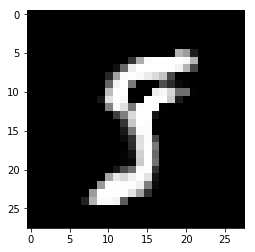

Iteration  17000
Loss dx: 0.24465455
Loss dg: 1.4599766
Loss gz: 0.72981215


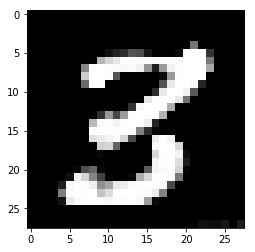

Iteration  18000
Loss dx: 1.0409999
Loss dg: 0.6275681
Loss gz: 0.78365254


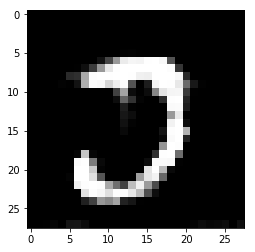

Iteration  19000
Loss dx: 0.5320066
Loss dg: 1.0156732
Loss gz: 1.1424904


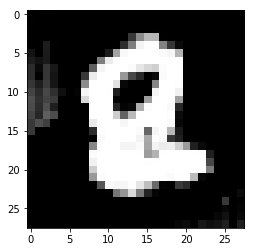

Iteration  20000
Loss dx: 2.5287247
Loss dg: 0.4039036
Loss gz: 0.0035806992


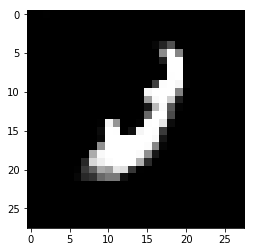

Iteration  21000
Loss dx: 0.75970095
Loss dg: 1.8708527
Loss gz: 1.2375703


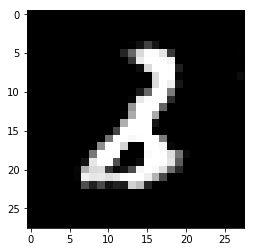

Iteration  22000
Loss dx: 1.0267584
Loss dg: 0.8508015
Loss gz: 0.95582855


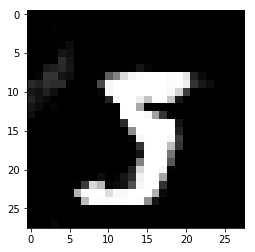

Iteration  23000
Loss dx: 0.010163838
Loss dg: 6.840358
Loss gz: 0.0070603844


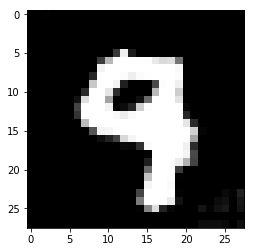

Iteration  24000
Loss dx: 1.8916466
Loss dg: 0.57489437
Loss gz: 0.31061307


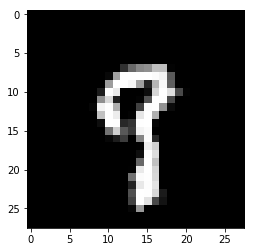

Iteration  25000
Loss dx: 1.0793569
Loss dg: 1.1774143
Loss gz: 0.99047065


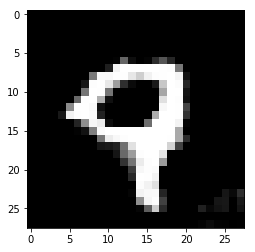

Iteration  26000
Loss dx: 0.46612507
Loss dg: 2.3937516
Loss gz: 0.63929355


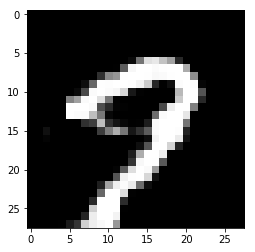

Iteration  27000
Loss dx: 1.5048294
Loss dg: 1.1799753
Loss gz: 0.60682106


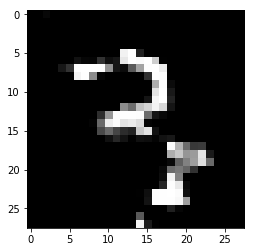

Iteration  28000
Loss dx: 1.0265142
Loss dg: 1.8989356
Loss gz: 2.5276942


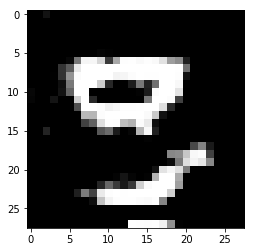

Iteration  29000
Loss dx: 1.4687641
Loss dg: 1.3463004
Loss gz: 0.9998163


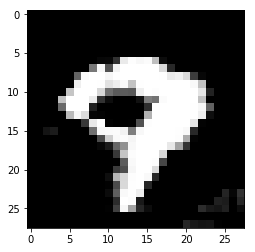

Iteration  30000
Loss dx: 3.0641131
Loss dg: 0.22876373
Loss gz: 2.7625015


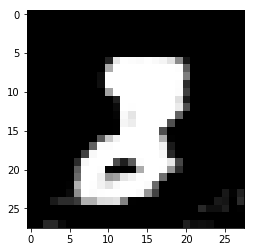

Iteration  31000
Loss dx: 2.3229325
Loss dg: 1.1492927
Loss gz: 1.1946535


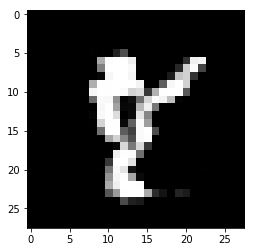

Iteration  32000
Loss dx: 1.133896
Loss dg: 1.9875752
Loss gz: 0.17627952


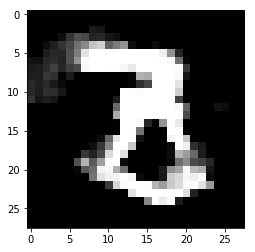

Iteration  33000
Loss dx: 1.5431278
Loss dg: 1.4914148
Loss gz: 1.460253


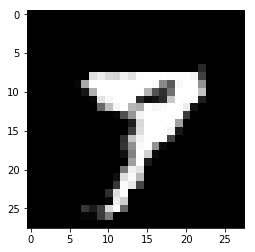

Iteration  34000
Loss dx: 1.3154738
Loss dg: 1.6535797
Loss gz: 0.491824


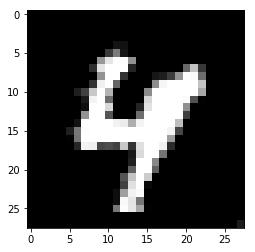

Iteration  35000
Loss dx: 1.7236865
Loss dg: 1.1888711
Loss gz: 0.7086724


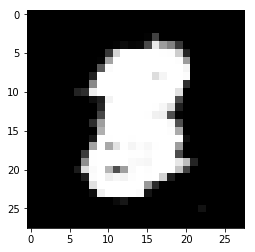

Iteration  36000
Loss dx: 1.0639291
Loss dg: 2.2524989
Loss gz: 0.56259274


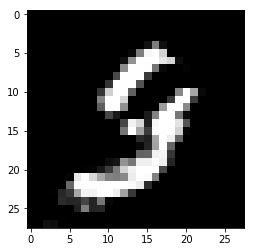

Iteration  37000
Loss dx: 1.2689126
Loss dg: 3.275966
Loss gz: 0.60022724


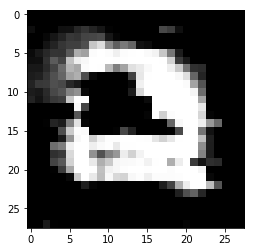

Iteration  38000
Loss dx: 3.7721863
Loss dg: 0.66784465
Loss gz: 0.4725096


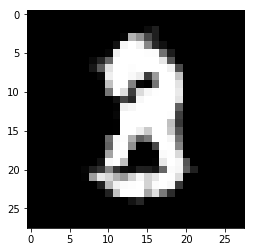

Iteration  39000
Loss dx: 2.0444694
Loss dg: 2.5021708
Loss gz: 0.55909985


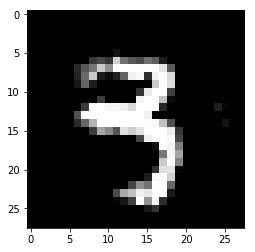

In [ ]:
mini_batch_size = 128

dataset_training = tf.data.Dataset.from_tensor_slices((train_X_normalized, train_y))
dataset_training = dataset_training.shuffle(buffer_size=train_X_normalized.shape[0]).repeat().batch(mini_batch_size)
it_training = dataset_training.make_one_shot_iterator()
gen_X_values,_ = it_training.get_next()

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    current_time = strftime("%Y_%m_%d__%H_%M", localtime())
    train_writer = tf.summary.FileWriter('./tensorboard/' + current_time, session.graph)
    
    for j in range(5_000_000//mini_batch_size):
        X_batch = session.run(gen_X_values)
        
        # Train the Discriminator
        _,_,loss_dx,loss_dg = session.run([dx_optimizer_tf, dg_optimizer_tf, dx_loss_avg_tf, dg_loss_avg_tf],
                          feed_dict={x:X_batch, z: gen_random_vec(mini_batch_size)})
        
        
        loss_gz = 0
        prev_loss_gz = 99999.0
        gen_iteration = 0
        
        while(prev_loss_gz > 1 and gen_iteration<10):
            # Train Generator
            _,output_gz,loss_gz = session.run([gz_optimizer_tf, Gz, gz_loss_avg_tf],
                                              feed_dict={z: gen_random_vec(mini_batch_size)})
            prev_loss_gz = loss_gz
            gen_iteration += 1
        
        if j%10 == 0:
            summary = session.run(merged,   feed_dict={x:X_batch, z: gen_random_vec(5)})
            train_writer.add_summary(summary, j)
        
        if j%1000 == 0:
            print('Iteration ',j)
            print('Loss dx:', loss_dx)
            print('Loss dg:', loss_dg)
            print('Loss gz:', loss_gz)
            plt.imshow(output_gz[0,:,:,0], cmap='gray', vmin=0, vmax=1)
            plt.show()


In [ ]:
session.close()

#### Results

As expected multiple training iterations of the generator per discriminator training iteration yields better results.
The losses of the discriminator and the generator are more balanced and as consequence there's a significant gradient the generator can use to adjust its weights.
With this technique the generator is able to produce some recognizable digits. However the results vary heavily in quality depending on the iteration and it's hard to keep the losses of both discriminator and generator in check without a heavy increase in training times. A lot of training iterations resulted in high losses for both the discriminator and the generator which is not a desirable outcome. To counter this behavior we probably have to dynamically increase the number of training steps for the discriminator too.

## Adding noise to discriminator training

One solution mentioned by the referenced paper is to add noise to the input of the generator to smooth the distribution.    
There are multiple ways to achieve this:
* Adding noise to the labels
* Adding noise to the classifier (e.g. by adding Dropout layers)

Regardless of the technique we expect the discriminator to converge more slowly, allowing the generator to catch up and improve. To verify our expectations we implement label smoothing and then train the discriminator and the generator at the same pace.



Instead of expecting 1 as label of the real images we now expect a smoothed value (e.g. 0.9) as label.
This adds some noise to the network and we expect higher losses for the discriminator, leading to better gradients for the generator.

Pretraining finished.
Iteration  0
Loss dx: 0.6529979
Loss dg: 0.7001889
Loss gz: 0.6829079


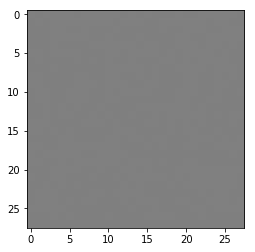

Iteration  100
Loss dx: 0.46022227
Loss dg: 0.36083102
Loss gz: 3.3252404


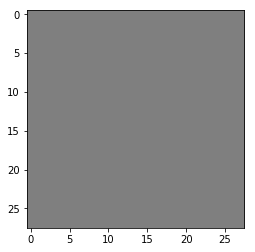

Iteration  200
Loss dx: 0.74773824
Loss dg: 0.4835919
Loss gz: 4.849536


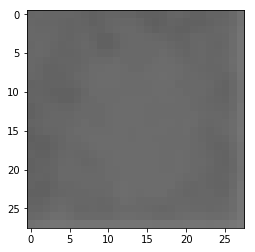

Iteration  300
Loss dx: 1.1080103
Loss dg: 0.3560586
Loss gz: 2.552714


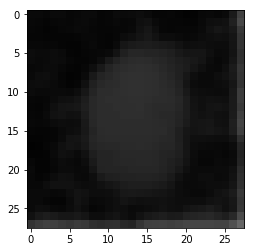

Iteration  400
Loss dx: 0.5373069
Loss dg: 0.4394613
Loss gz: 1.4231077


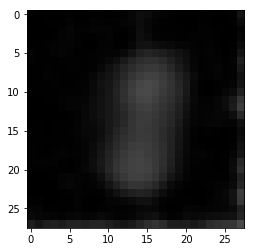

Iteration  500
Loss dx: 0.37827864
Loss dg: 0.49458027
Loss gz: 1.113875


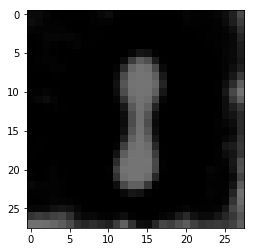

Iteration  600
Loss dx: 0.4193427
Loss dg: 0.45491016
Loss gz: 1.2493374


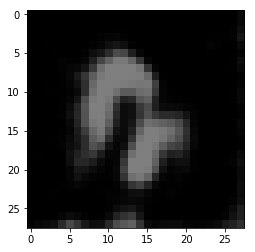

Iteration  700
Loss dx: 0.4729257
Loss dg: 0.43003207
Loss gz: 1.364218


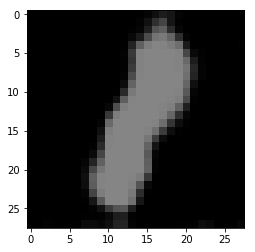

Iteration  800
Loss dx: 0.5426872
Loss dg: 0.7770091
Loss gz: 1.3192935


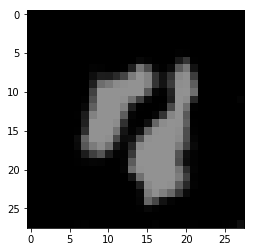

Iteration  900
Loss dx: 0.404384
Loss dg: 0.53298277
Loss gz: 0.9608541


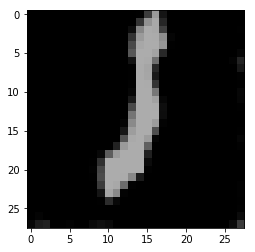

Iteration  1000
Loss dx: 0.36671987
Loss dg: 0.7299852
Loss gz: 0.65329456


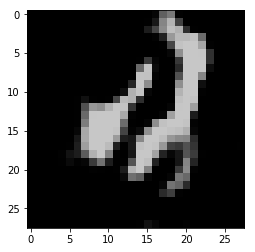

Iteration  1100
Loss dx: 0.3649645
Loss dg: 0.8220847
Loss gz: 0.5620868


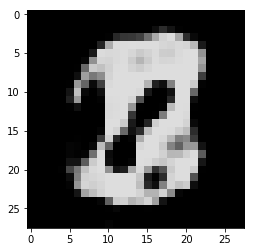

Iteration  1200
Loss dx: 0.37096435
Loss dg: 0.90187544
Loss gz: 0.50889087


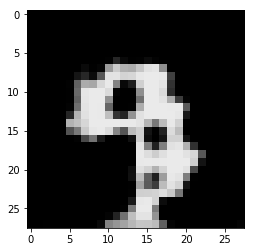

Iteration  1300
Loss dx: 0.3677386
Loss dg: 0.99327797
Loss gz: 0.45462814


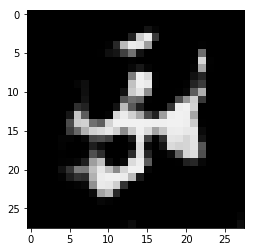

Iteration  1400
Loss dx: 0.36382112
Loss dg: 1.047766
Loss gz: 0.42085028


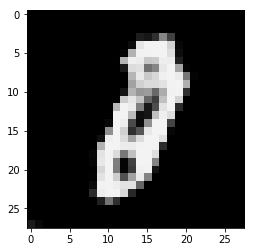

Iteration  1500
Loss dx: 0.36230034
Loss dg: 1.07365
Loss gz: 0.39497045


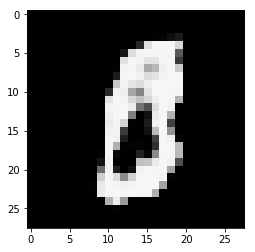

Iteration  1600
Loss dx: 0.36390895
Loss dg: 1.0957801
Loss gz: 0.3878433


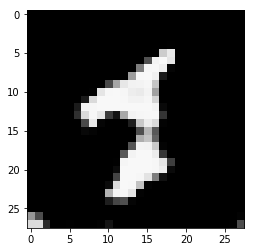

Iteration  1700
Loss dx: 0.3649368
Loss dg: 1.0980145
Loss gz: 0.380864


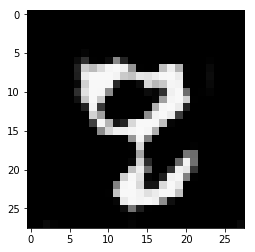

Iteration  1800
Loss dx: 0.3625765
Loss dg: 1.0895482
Loss gz: 0.39057603


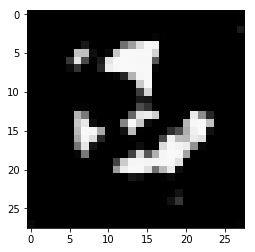

Iteration  1900
Loss dx: 0.36137784
Loss dg: 1.0963216
Loss gz: 0.38288835


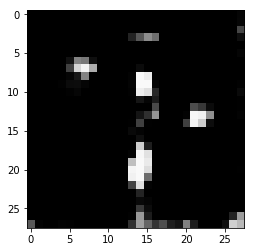

Iteration  2000
Loss dx: 0.36226737
Loss dg: 1.0921988
Loss gz: 0.37878865


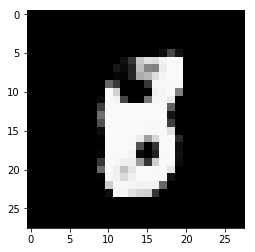

Iteration  2100
Loss dx: 0.3621595
Loss dg: 1.0899025
Loss gz: 0.37766284


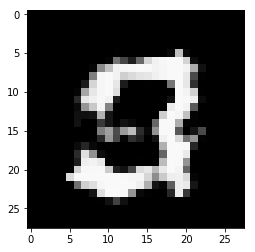

Iteration  2200
Loss dx: 0.3637878
Loss dg: 1.1007246
Loss gz: 0.3748351


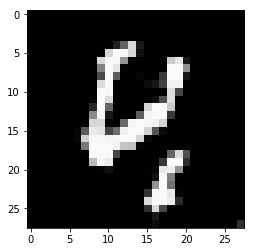

Iteration  2300
Loss dx: 0.36272228
Loss dg: 1.1042303
Loss gz: 0.37317717


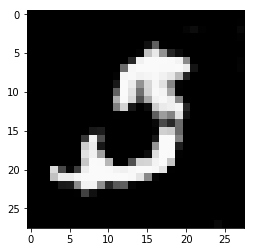

Iteration  2400
Loss dx: 0.36280224
Loss dg: 1.0962262
Loss gz: 0.3859036


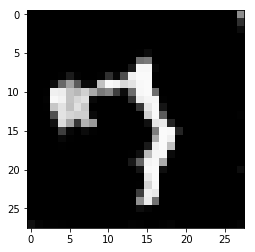

In [ ]:
# We add noise to our labels to lower the overall confidence of the classification

# Discriminator for real images -> We use ones as labels (with additional smoothing)
smooth = 0.1
dx_loss_tf = tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)*(1.0-smooth))
dx_loss_avg_tf = tf.reduce_mean(dx_loss_tf)

# Discriminator for fake images -> We use zeros as labels 
dg_loss_tf = tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)+smooth)
dg_loss_avg_tf = tf.reduce_mean(dg_loss_tf)

# The generator procudes fake images labeled as real images.
# -> It tries to maximize the loss of the discriminator. By optimizing the generator loss
# we achieve generated images that look real to the discriminator.
gz_loss_tf = tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg))
gz_loss_avg_tf = tf.reduce_mean(gz_loss_tf)

mini_batch_size = 2048

dataset_training = tf.data.Dataset.from_tensor_slices((train_X_normalized, train_y))
dataset_training = dataset_training.shuffle(buffer_size=train_X_normalized.shape[0]).repeat().batch(mini_batch_size)
it_training = dataset_training.make_one_shot_iterator()
gen_X_values,_ = it_training.get_next()

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    current_time = strftime("%Y_%m_%d__%H_%M", localtime())
    train_writer = tf.summary.FileWriter('./tensorboard/' + current_time,
                                      session.graph)
    
    # Pretraining
    for i in range(20_000//mini_batch_size):
    
        X_batch = session.run(gen_X_values)
    
        # Train the Discriminator
        _,_,loss_dx,loss_dg = session.run([dx_optimizer_tf, dg_optimizer_tf, dx_loss_avg_tf, dg_loss_avg_tf],
                          feed_dict={x:X_batch, z: gen_random_vec(mini_batch_size)})
            
    print('Pretraining finished.')
    
    for j in range(5_000_000//mini_batch_size):
        X_batch = session.run(gen_X_values)
    
        # Train the Discriminator
        _,_,loss_dx,loss_dg = session.run([dx_optimizer_tf, dg_optimizer_tf, dx_loss_avg_tf, dg_loss_avg_tf],
                          feed_dict={x:X_batch, z: gen_random_vec(mini_batch_size)})
        
        # Train Generator
        _,output_gz,loss_gz = session.run([gz_optimizer_tf, Gz, gz_loss_avg_tf],
                                          feed_dict={z: gen_random_vec(mini_batch_size)})
        
        if j%10 == 0:
            summary = session.run(merged,   feed_dict={x:X_batch, z: gen_random_vec(5)})
            train_writer.add_summary(summary, j)
        
        if j%100 == 0:
            print('Iteration ',j)
            print('Loss dx:', loss_dx)
            print('Loss dg:', loss_dg)
            print('Loss gz:', loss_gz)
            plt.imshow(output_gz[0,:,:,0], cmap='gray', vmin=0, vmax=1)
            plt.show()

#### Result

Oh well, that didn't help much. Even though the discriminator losses never come close to zero the quality of the generated images only improved slightly.
Some digits are already identifiable, but the overall quality of the generator's output remains bad.

## Change the Loss Function to Wasserstein Distance
[Wasserstein GANs (WGAN)](https://arxiv.org/pdf/1701.07875.pdf) are an alternative to *classical* GANs. They use a different loss function and proved to be more stable to hyperparameter selection. While the paper offers a good theoretical introduction and reasoning why they perform better in many cases, [this article](https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/) provides a good practical introduction.

In [11]:
# Step 1: "we modify our loss by simply removing the log"
D_loss = tf.reduce_mean(Dx) - tf.reduce_mean(Dg)
G_loss = -tf.reduce_mean(Dg)

# Step 2: "We then clip the weight of D after each gradient descent update:"
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in tf.trainable_variables(scope='discriminator')]

# Step 3: Create our optimizers. We now use RMSProp instead of Adam as stated in the linked paper.
D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-5)
            .minimize(-D_loss, var_list=tf.trainable_variables(scope='discriminator')))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-5)
            .minimize(G_loss, var_list=tf.trainable_variables(scope='generator')))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Pretraining finished.
Iteration  0
Loss d: -3.6649042e-05
Loss gz: -0.000111865054


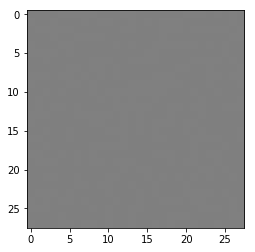

Iteration  100
Loss d: 20.061558
Loss gz: 21.37388


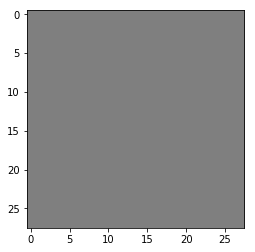

Iteration  200
Loss d: 24.420246
Loss gz: 22.434689


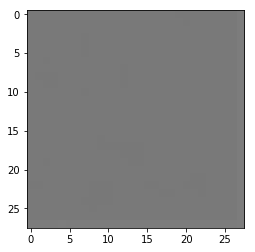

Iteration  300
Loss d: 21.886858
Loss gz: 18.658894


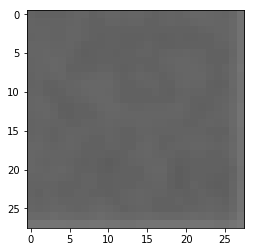

Iteration  400
Loss d: 15.100466
Loss gz: 9.124575


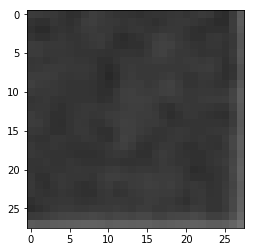

Iteration  500
Loss d: 12.547565
Loss gz: 1.0032622


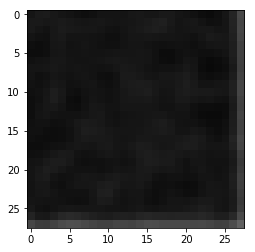

Iteration  600
Loss d: 12.9316225
Loss gz: -0.28347695


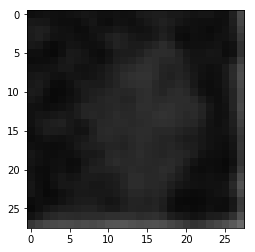

Iteration  700
Loss d: 11.150078
Loss gz: -1.6288667


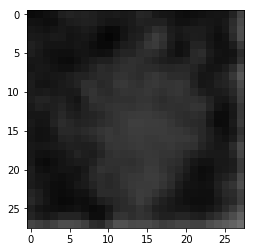

Iteration  800
Loss d: 7.9300942
Loss gz: -4.875958


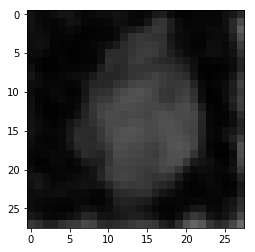

Iteration  900
Loss d: 3.0192647
Loss gz: -7.927833


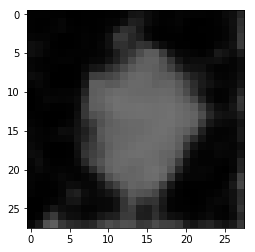

Iteration  1000
Loss d: 1.4050726
Loss gz: 1.0691967


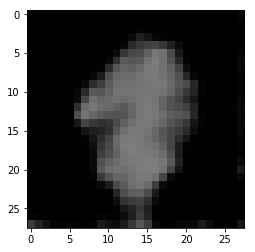

Iteration  1100
Loss d: 1.1782289
Loss gz: -0.08216338


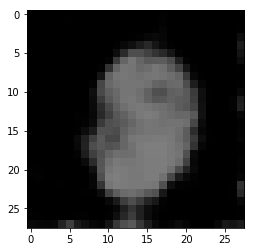

Iteration  1200
Loss d: 0.5462425
Loss gz: -0.27523163


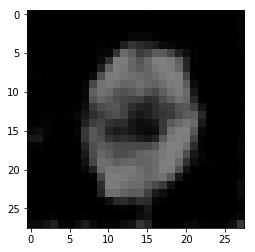

Iteration  1300
Loss d: 0.6374613
Loss gz: 0.19959486


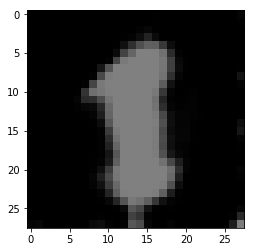

Iteration  1400
Loss d: 0.99999607
Loss gz: -1.0816977


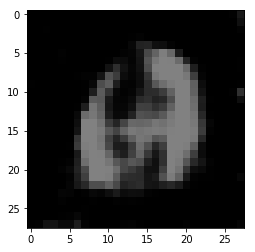

Iteration  1500
Loss d: 1.1087554
Loss gz: -1.3072934


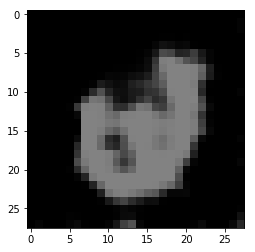

Iteration  1600
Loss d: 2.1410136
Loss gz: -3.1889906


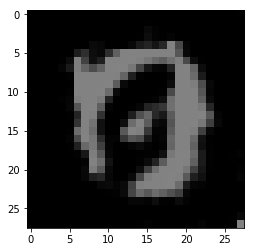

Iteration  1700
Loss d: 2.5078063
Loss gz: -5.478132


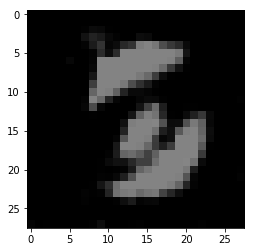

Iteration  1800
Loss d: 2.7284923
Loss gz: -4.592606


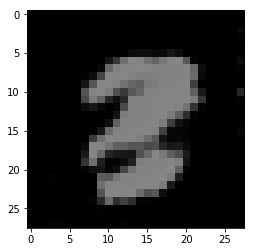

Iteration  1900
Loss d: 2.357585
Loss gz: -4.494485


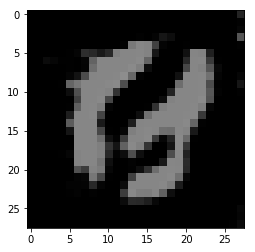

Iteration  2000
Loss d: 2.37893
Loss gz: -4.0961947


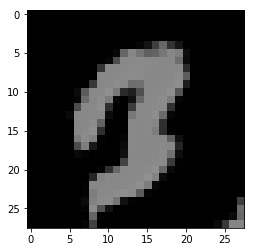

Iteration  2100
Loss d: 2.430534
Loss gz: -2.7106786


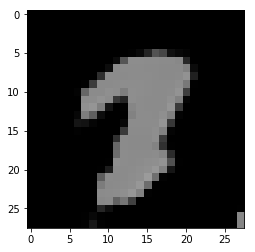

Iteration  2200
Loss d: 2.04472
Loss gz: -3.2490616


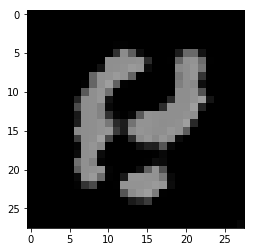

Iteration  2300
Loss d: 1.8009448
Loss gz: -3.9330807


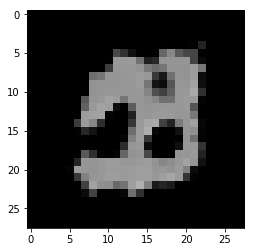

Iteration  2400
Loss d: 1.5846274
Loss gz: -3.7376258


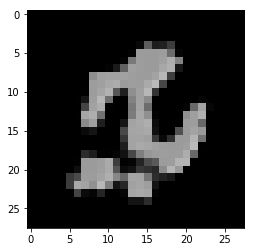

In [ ]:
# Step 4: Train the WGAN
mini_batch_size = 2048

dataset_training = tf.data.Dataset.from_tensor_slices((train_X_normalized, train_y))
dataset_training = dataset_training.shuffle(buffer_size=train_X_normalized.shape[0]).repeat().batch(mini_batch_size)
it_training = dataset_training.make_one_shot_iterator()
gen_X_values,_ = it_training.get_next()

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    current_time = strftime("%Y_%m_%d__%H_%M", localtime())
    train_writer = tf.summary.FileWriter('./tensorboard/' + current_time,
                                      session.graph)
    
    # Pretraining
    for i in range(20_000//mini_batch_size):
    
        X_batch = session.run(gen_X_values)
    
        # Train the Discriminator
        _, loss_d, _ = session.run([D_solver, D_loss, clip_D],
                          feed_dict={x:X_batch, z: gen_random_vec(mini_batch_size)})
            
    print('Pretraining finished.')
    
    for j in range(5_000_000//mini_batch_size):
        
        for k in range(5):
            X_batch = session.run(gen_X_values)
    
            # Train the Discriminator
            _, loss_d, _ = session.run([D_solver, D_loss, clip_D],
                              feed_dict={x:X_batch, z: gen_random_vec(mini_batch_size)})
        
        # Train Generator
        _, output_gz, loss_gz = session.run([G_solver, Gz, G_loss],
                                          feed_dict={z: gen_random_vec(mini_batch_size)})
        
        if j%10 == 0:
            summary = session.run(merged,   feed_dict={x:X_batch, z: gen_random_vec(5)})
            train_writer.add_summary(summary, j)
            pass
            
        
        if j%100 == 0:
            print('Iteration ',j)
            print('Loss d:', loss_d)
            print('Loss gz:', loss_gz)
            plt.imshow(output_gz[0,:,:,0], cmap='gray', vmin=0, vmax=1)
            plt.show()

### Results

Using the Wasserstein Distance as loss provides better gradients for the generator to adjust its weights compared to our first vanilla GAN without any modifications. The WGAN was able to generate at least some readable digits, though most of the output was not usable in any way.
Most likely some more hyperparameters, like the length of the training and/or the iteration-ratio between discriminator and generator have to be fine-tuned for better results.

## Conclusion

In this notebook we implemented a simple GAN trained on the MNIST dataset.    
We first introduced a vanilla GAN using the binary cross entropy as a loss function to train the discriminator and the generator. Even though the first attempt learned to produce more than just noise it wasn't able to generate recognizable digits. After investigating possible reasons we came to the conclusion that our discriminator could classify the real and fake images too well, resulting in a loss near 0 and therefore vanishing gradients and insufficient feedback to train the generator with.

We then tried to improve the GAN by various modifications. First we tried to balance the loss of the discriminator and the generator by training the generator multiple times per iteration of the discriminator. The network then started to learn how to generate hand written digits, but nevertheless the training was highly unstable. The results of this modification ranged from well recognizable digits to seemingly random structures depending on the iteration.    

The second modification of the network consisted of adding noise to the discriminator. The intuition behind this change is to slow down its learning progress to allow the generator to catch up by providing usable gradients.    
The results of this modification are comparable to our first modification. The generated outputs ranged from totally unrecognizable structures to readable digits.

Finally we implemented a Wasserstein GAN (WGAN). The WGAN outperformed the vanilla GAN significantly. However the results still are not satisfying. Presumably further hyperparameters tweaks of the WGAN are necessary to achieve a noticable better output compared to our other GAN variations.

Even though the basic theory behind GANs is not hard to understand the implementations seem to be really unstable and prone to hyperparemeter changes. The quality of a GAN and its settings can not be judged early as it needs a lot of iterations to learn to produce some desired output.